### Imports

In [63]:
# imports
import torch as pt
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from ml_funcs import progress_viewer
import torchmetrics as tm

In [64]:
# Hyper parameters
RANDOM_SEED = 42
N_SAMPLES = 1000
NOISE = 0.2

### Create dataset

In [65]:
from sklearn.datasets import make_moons

X_moon, y_moon = make_moons(n_samples=N_SAMPLES,
                  noise=NOISE,
                  random_state=RANDOM_SEED)

# print(X_moon,y_moon)
print(X_moon.shape, y_moon.shape)
print(type(X_moon), type(y_moon))

(1000, 2) (1000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [66]:
# turn to a dataframe
from sys import path
df = pd.concat((pd.DataFrame(X_moon, columns=[0,1]),pd.DataFrame(y_moon, columns=[2])), axis=1)
df.to_csv(f"{path[0]}/moon_df.csv", index=False)

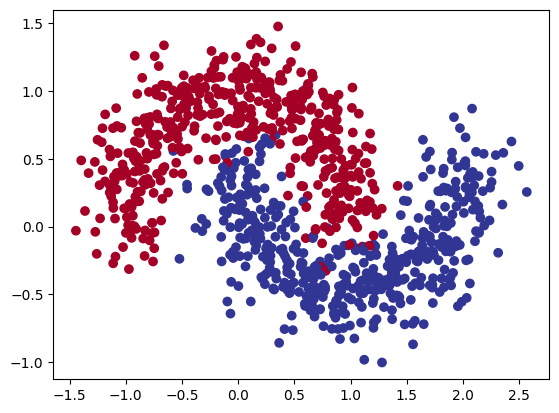

In [67]:
# Visualize the data on a scatter plot
plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moon,cmap=plt.cm.RdYlBu)
plt.show()

In [68]:
X_moon = pt.from_numpy(X_moon).type(pt.float)
y_moon = pt.from_numpy(y_moon).type(pt.float)

from sklearn.model_selection import train_test_split

X_moon_train,X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon,y_moon, test_size=0.2, random_state=RANDOM_SEED)

### Build the model

In [1]:
pt.manual_seed(42)
class MoonModelV0(nn.Module):
    def __init__(self, hidden_features):
        
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=1)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
model_0 = MoonModelV0(10)
model_0

NameError: name 'pt' is not defined

In [70]:
X_moon_train.shape, y_moon_train.shape, X_moon_test.shape, y_moon_test.shape
#print(X_moon_train)

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [71]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = pt.optim.SGD(params=model_0.parameters(), lr=0.1)

acc_fn = tm.Accuracy("binary", num_classes=2)


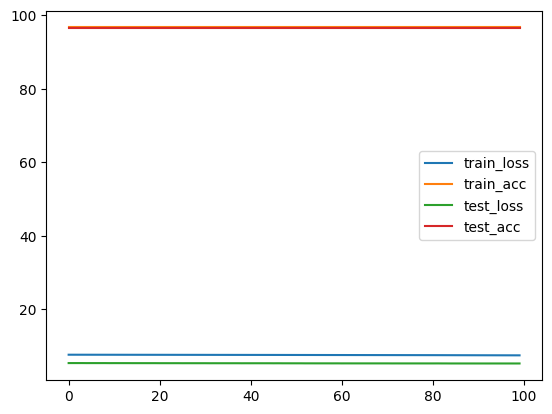

In [85]:
device = "cuda" if pt.cuda.is_available() else "cpu"

epochs = 100

X_moon_train, y_moon_train = X_moon_train.to(device).squeeze(), y_moon_train.to(device).squeeze()
X_moon_test, y_moon_test = X_moon_test.to(device).squeeze(), y_moon_test.to(device).squeeze()

pv = progress_viewer()

for epoch in range(epochs):
    model_0.train()
    #print(X_moon_train.shape)
    y_logits = model_0(X_moon_train).squeeze()
    y_pred_probs = pt.sigmoid(y_logits)
    y_preds = pt.round(y_logits)
    loss = loss_fn(y_logits, y_moon_train)
    #print(loss)
    acc = acc_fn(y_preds, y_moon_train)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with pt.inference_mode():
        y_test_logits = model_0(X_moon_test).squeeze()
        y_test_preds = pt.round(pt.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_moon_test)
        test_acc = acc_fn(y_test_preds, y_moon_test)
    pv.add(loss.item(), acc.item()*100, test_loss.item(), test_acc.item()*100)
pv.show()



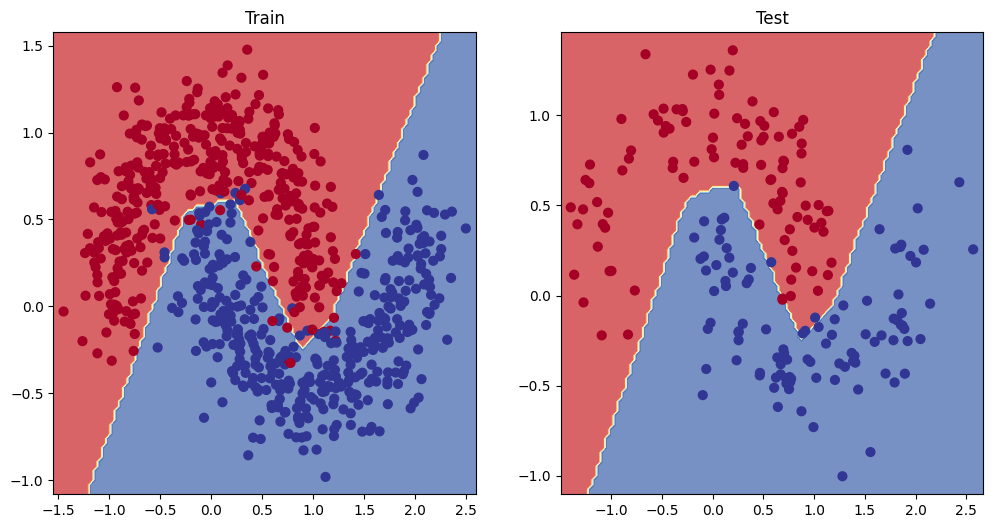

In [86]:
# view
import helper_functions
def view_results(X_train, y_train, X_test, y_test, model):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("Train")
    helper_functions.plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1,2,2)
    plt.title("Test")
    helper_functions.plot_decision_boundary(model, X_test, y_test)
view_results(X_moon_train, y_moon_train, X_moon_test, y_moon_test, model_0)